### Make a copy of this note if you want to analyze 

#### Please run panta first to get gene clusters and other output files for this analysis

In [1]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install pygraphviz

In [2]:
# Parameters of the algorithm
highlight_genome_seq = [0] # the sequence we want to set very large weights ([] if None)
only_two_weight = False # there are only two weights (highlighted vs non-highlighted genome)

In [3]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [4]:
# data_dir = "../panta/examples/test/output/"
# data_dir = "data/genome_graph_test/"
# you can take the data in the directory: data/genome_graph_test
data_dir = "../panta/examples/test/output_Kp30mix/"

In [5]:
sample_info = pd.read_csv(data_dir + "samples.tsv", delimiter='\t', header=None)

In [46]:
sample_info.head(3)

,0,1
0,GCF_000009885.1_ASM988v1_genomic,0
1,GCF_000016305.1_ASM1630v1_genomic,1
2,GCF_000220485.1_ASM22048v1_genomic,2


In [7]:
gene_info = pd.read_csv(data_dir + "gene_info.tsv", delimiter='\t', header=None)
gene_info.columns =['GeneName', 'SampleID', 'clusterID']

In [8]:
## select some sample
# selected_samples = [0, 1, 9]
# gene_info = gene_info.loc[gene_info['SampleID'].isin(selected_samples)]
gene_info.head(2)

,GeneName,SampleID,clusterID
0,0_48251,0,0
1,2_4983-1,2,0


In [9]:
gene_position = pd.read_csv(data_dir + 'gene_position.tsv', delimiter='\t', header=None)
gene_position.columns =['SampleID', 'ContigName', 'GeneSequence']

In [10]:
# gene_position = gene_position.loc[gene_position['SampleID'].isin(selected_samples)]
gene_position.head(3)

,SampleID,ContigName,GeneSequence
0,0,NC_012731.1,0_1-1;0_2-1;0_31;0_4-1;0_5-1;0_61;0_71;0_81;0_...
1,0,NC_006625.1,0_47981;0_4799-1;0_4800-1;0_4801-1;0_48021;0_4...
2,1,NC_009648.1,1_11;1_21;1_31;1_41;1_5-1;1_6-1;1_71;1_81;1_91...


In [11]:
# sort by length of contigs
gene_position.sort_values(by="GeneSequence", key=lambda x: x.str.len(),  ascending=False, inplace=True)

In [12]:
gene_position.head(3)

,SampleID,ContigName,GeneSequence
166,25,NZ_CP009771.1,25_1-1;25_2-1;25_31;25_4-1;25_5-1;25_61;25_71;...
170,26,NZ_CP009775.1,26_1-1;26_2-1;26_31;26_4-1;26_5-1;26_61;26_71;...
75,18,NZ_CP008797.1,18_1-1;18_2-1;18_31;18_4-1;18_5-1;18_61;18_71;...


In [13]:
gene_position.loc[gene_position["SampleID"]==18]

,SampleID,ContigName,GeneSequence
75,18,NZ_CP008797.1,18_1-1;18_2-1;18_31;18_4-1;18_5-1;18_61;18_71;...
76,18,NZ_CP008800.1,18_50771;18_5078-1;18_5079-1;18_5080-1;18_5081...
77,18,NZ_CP008798.1,18_52701;18_52711;18_52721;18_5273-1;18_5274-1...
78,18,NZ_CP008799.1,18_5356-1;18_5357-1;18_5358-1;18_5359-1;18_536...


In [14]:
print("List of all samples")
n_samples = len(np.unique(gene_position.iloc[:,0]))
np.unique(gene_position.iloc[:,0])

List of all samples


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

# Run here

In [15]:
%load_ext autoreload
%autoreload 2
from pangraph import PanGraph

In [16]:
# construct the pangenome graph
# min_contig_len = 100
pangraph = PanGraph(sample_info=sample_info, gene_info=gene_info, gene_position=gene_position)

In [17]:
H = pangraph.construct_graph(method = "graph_alignment", sample_id_ref = None,  min_contig_len = 20) # use the same min_contig_len when generate the ground truth

Set minimum on len of contigs =  20 NUMBER OF COMPUTED CONTIGS: 1092


In [18]:
# nx.write_gml(H,'cytoscape_out/pan_graph.gml')

In [19]:
# number of nodes and edges
pangraph.n_clusters, H.number_of_edges()

(320343, 22387)

In [20]:
S = [H.subgraph(c).copy() for c in nx.weakly_connected_components(H)]
# if you want a largest component
# largest_cc = max(nx.weakly_connected_components(G), key=len)

In [21]:
## sort components by size
S.sort(key=lambda x: x.number_of_nodes(), reverse=True)

In [22]:
len(S)

305116

In [23]:
for i in range(len(S)):
    if S[i].number_of_edges() > 5:
        print(i, S[i].number_of_edges(), ",")

0 22179 ,
1 72 ,
2 67 ,
3 36 ,
4 33 ,


In [24]:
# G = H.subgraph(["C-" + str(i) for i in range (500)])
G = S[0].copy()

In [25]:
G.number_of_nodes(), G.number_of_edges()

(15020, 22179)

In [26]:
nx.write_gml(G,'cytoscape_out/a_pangraph_component.gml')

In [27]:
G_contract = G.copy()

In [28]:
## remove node of in_degree = out_degree = 1 and degree = 0
for node in list(G_contract.nodes()):
    if G_contract.in_degree(node) == 1 and G_contract.out_degree(node) == 1:
        in_edges = list(G_contract.in_edges(node))
        out_edges = list(G_contract.out_edges(node))
        if G_contract[in_edges[0][0]][in_edges[0][1]]['weight'] == G_contract[out_edges[0][0]][out_edges[0][1]]['weight']:
            G_contract.add_edge(in_edges[0][0], out_edges[0][1], weight = G_contract[in_edges[0][0]][in_edges[0][1]]['weight'])
            G_contract.remove_node(node)
    if G_contract.in_degree(node) == 0 and G_contract.out_degree(node) == 0:
        G_contract.remove_node(node)

In [29]:
G_contract.number_of_nodes(), G_contract.number_of_edges()

(6375, 12560)

In [30]:
nx.write_gml(G_contract,'cytoscape_out/a_simplified_pangraph_component.gml')

In [31]:
G.number_of_nodes(), G.number_of_edges(), G_contract.number_of_nodes(), G_contract.number_of_edges()

(15020, 22179, 6375, 12560)

In [32]:
# Note that this cluster might not in the final graph because we only select the contig with more than 200 genes.
cluster_id = 2046
# for cluster_id in range(3701, 3710):
df = gene_info.loc[gene_info.iloc[:,2]==cluster_id]
print(df)
print("Gene -> Contig: ", end =" ")
for i in range(len(df.index)):
    print(df.iloc[i,0], "->", pangraph.gene2contigs_dict[df.iloc[i,0]], end =", ")

       GeneName  SampleID  clusterID
33239  3_1870-1         3       2046
Gene -> Contig:  3_1870-1 -> 24, 

In [33]:
# import pyttsx3
# engine = pyttsx3.init()
# engine.say(G.number_of_nodes())
# engine.say("The reduced graph has ")
# engine.say(G_contract.number_of_nodes())
# engine.say(G_contract.number_of_nodes())
# engine.say("Number of genomes: ")
# engine.say(n_samples)
# engine.say(n_samples)
# engine.runAndWait()

In [34]:
# gene_contigs = gene_position.iloc[0,2].split(";")

In [43]:
contig_graph = pangraph.join_contig(sample_id=21)

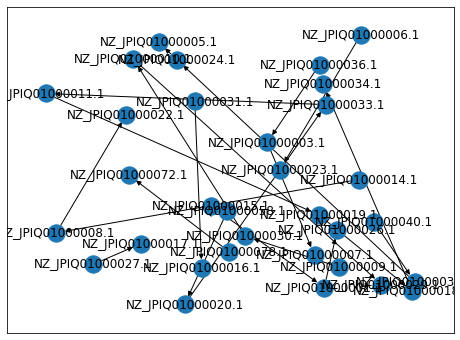

In [44]:
plt.figure(3,figsize=(8,6)) 
nx.draw_networkx(contig_graph, pos=nx.random_layout(contig_graph), with_labels=True)
plt.show()

In [49]:
# nx.write_gml(contig_graph,'cytoscape_out/contig_graph_SAMN02768808.gml')

In [48]:
pangraph.edge_list

[['NZ_JPIQ01000036.1', 'NZ_JPIQ01000003.1'],
 ['NZ_JPIQ01000020.1', 'NZ_JPIQ01000033.1'],
 ['NZ_JPIQ01000030.1', 'NZ_JPIQ01000010.1'],
 ['NZ_JPIQ01000027.1', 'NZ_JPIQ01000017.1'],
 ['NZ_JPIQ01000015.1', 'NZ_JPIQ01000001.1'],
 ['NZ_JPIQ01000033.1', 'NZ_JPIQ01000011.1'],
 ['NZ_JPIQ01000003.1', 'NZ_JPIQ01000007.1'],
 ['NZ_JPIQ01000010.1', 'NZ_JPIQ01000029.1'],
 ['NZ_JPIQ01000011.1', 'NZ_JPIQ01000019.1'],
 ['NZ_JPIQ01000019.1', 'NZ_JPIQ01000018.1'],
 ['NZ_JPIQ01000009.1', 'NZ_JPIQ01000030.1'],
 ['NZ_JPIQ01000018.1', 'NZ_JPIQ01000034.1'],
 ['NZ_JPIQ01000024.1', 'NZ_JPIQ01000005.1'],
 ['NZ_JPIQ01000008.1', 'NZ_JPIQ01000022.1'],
 ['NZ_JPIQ01000006.1', 'NZ_JPIQ01000023.1'],
 ['NZ_JPIQ01000031.1', 'NZ_JPIQ01000016.1'],
 ['NZ_JPIQ01000078.1', 'NZ_JPIQ01000072.1'],
 ['NZ_JPIQ01000014.1', 'NZ_JPIQ01000008.1'],
 ['NZ_JPIQ01000032.1', 'NZ_JPIQ01000024.1'],
 ['NZ_JPIQ01000001.1', 'NZ_JPIQ01000026.1'],
 ['NZ_JPIQ01000058.1', 'NZ_JPIQ01000020.1'],
 ['NZ_JPIQ01000040.1', 'NZ_JPIQ01000032.1']]